In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass


In [2]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(PATH, seed=1, shuffle=True, image_size=IMAGE_SIZE, batch_size=32)

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


Found 4094 files belonging to 4 classes.


In [3]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(PATH, seed=1, shuffle=True, image_size=IMAGE_SIZE, batch_size=32)

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


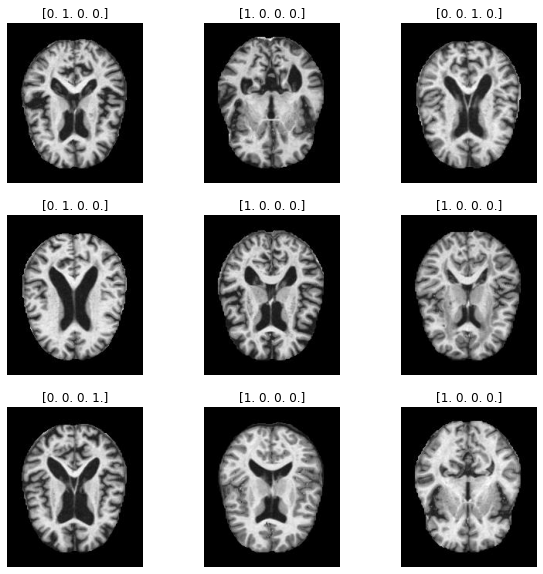

In [4]:
# plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

In [5]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(208, 176, 3)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [6]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [7]:
#model.summary()


In [8]:
train_set_length = train_ds.cardinality().numpy()
EPOCHS = 40
BATCH_SIZE = 4
STEPS_PER_EPOCH = train_set_length // BATCH_SIZE

val_set_length = val_ds.cardinality().numpy()
val_BATCH_SIZE = 4
val_STEPS_PER_EPOCH = val_set_length // BATCH_SIZE


In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.0001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [10]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              #loss="binary_crossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

with tf.device("/gpu:0"):
    history = model.fit(train_ds,
                        epochs=EPOCHS, 
                        #batch_size=BATCH_SIZE,
                        #steps_per_epoch=STEPS_PER_EPOCH,
                        shuffle=True,
                        validation_data=val_ds)
                        #validation_steps=val_STEPS_PER_EPOCH,)
                        #validation_batch_size=val_BATCH_SIZE)
                    

Epoch 1/40
128/128 [==============================] - 9s 50ms/step - loss: 1.2542 - precision: 0.5236 - recall: 0.2191 - auc: 0.7486 - val_loss: 1.0385 - val_precision: 0.6901 - val_recall: 0.3340 - val_auc: 0.8144
Epoch 2/40
128/128 [==============================] - 6s 43ms/step - loss: 1.0452 - precision: 0.6295 - recall: 0.2416 - auc: 0.7925 - val_loss: 1.0056 - val_precision: 0.8760 - val_recall: 0.2064 - val_auc: 0.8410
Epoch 3/40
128/128 [==============================] - 6s 43ms/step - loss: 0.9922 - precision: 0.6990 - recall: 0.2621 - auc: 0.8119 - val_loss: 0.9421 - val_precision: 0.7864 - val_recall: 0.3155 - val_auc: 0.8558
Epoch 4/40
128/128 [==============================] - 6s 43ms/step - loss: 0.9484 - precision: 0.6776 - recall: 0.2777 - auc: 0.8271 - val_loss: 0.8563 - val_precision: 0.8506 - val_recall: 0.3272 - val_auc: 0.8752
Epoch 5/40
128/128 [==============================] - 6s 43ms/step - loss: 0.9099 - precision: 0.6955 - recall: 0.2846 - auc: 0.8374 - val_l

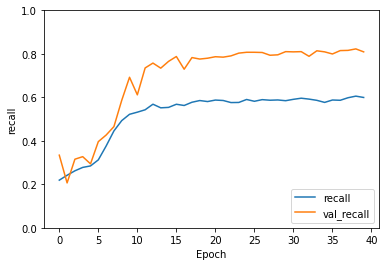

In [11]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [12]:
input_dataset = train_ds.map(lambda x,y: x)
target_dataset = train_ds.map(lambda x,y: y)

X_train = np.concatenate([np.reshape(element.numpy(),[1,208,176,3]) for element in input_dataset.unbatch()])
y_train = np.concatenate([np.reshape(element.numpy(),[1,4]) for element in target_dataset.unbatch()])

In [13]:
input_dataset = val_ds.map(lambda x,y: x)
target_dataset = val_ds.map(lambda x,y: y)

X_val = np.concatenate([np.reshape(element.numpy(),[1,208,176,3]) for element in input_dataset.unbatch()])
y_val = np.concatenate([np.reshape(element.numpy(),[1,4]) for element in target_dataset.unbatch()])


In [14]:
y_pred = model.predict(X_val, batch_size=1, verbose=1)

test_loss, test_prec, test_rec, test_auc  = model.evaluate(X_val, y_val, verbose=2)

1027/1027 [==============================] - 2s 1ms/step
33/33 - 1s - loss: 3.1347 - precision: 0.4510 - recall: 0.3856 - auc: 0.7037 - 536ms/epoch - 16ms/step


MACRO ROC AUC SCORE: 0.5032398713511506


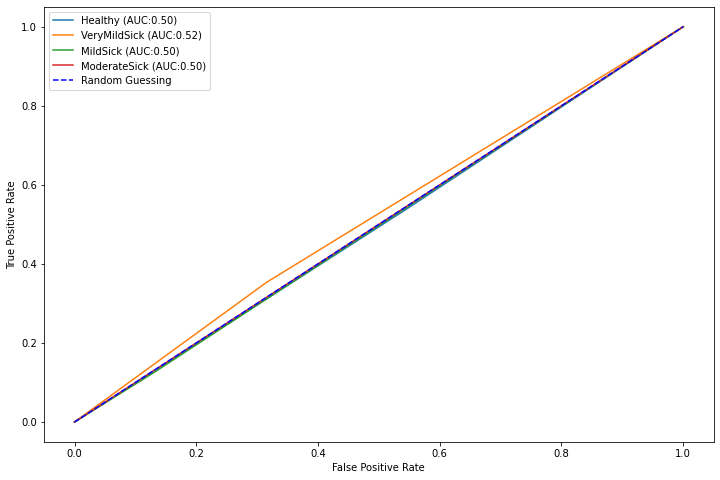

In [15]:
roc_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

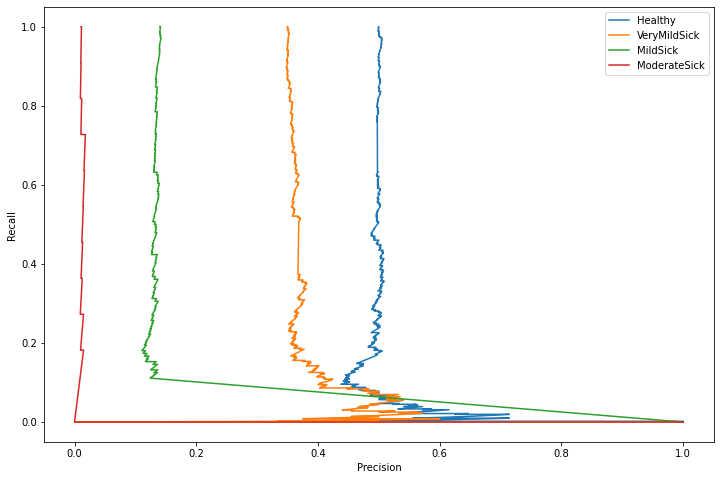

In [16]:
precision_recall_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [17]:
def roc_multiclass(y_pred,y_val,target_list,variant):
    
    '''
    Args:   y_pred - raw output of model prediction (should be real proba values)
            y_val - validation set as used in cnn model (should be sparse dummy columns)
            target_list - list containing targets as strings
            variant - "macro" or "micro": sets the averaging method 
    retuns: Plots the individual Roc-auc curves of every class.
            Also prints the "macro" or "micro" average Roc-auc-score
    '''


    # flatten CNN output in such way that we change the sparse columns (each only containing 0 and 1)
    # to one column labeling classes as continues numbers. e.g. 1,2,3,4 (etc)
    y_pred = np.argmax(y_pred,axis=-1)
    y_val = np.argmax(y_val, axis=-1)

    # set plot figure size
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

    # core function: here the roc score is calculated. The estimator results are calculated for all
    # thresholds. Macro sets the evaluation to "one vs all".
    # Multiclass_roc_auc_score is acutually the roc_auc_score function of sklearn
    # within this Multiclass_roc_auc_score function the roc_curve of each individual class is calculated
    # and plotted (see loop)
    def multiclass_roc_auc_score(y_val, y_pred, average=variant):
        # creates dummy columns so we have one for each class (with 0s and 1s)
        lb = LabelBinarizer()   
        lb.fit(y_val)
        y_val = lb.transform(y_val)
        y_pred = lb.transform(y_pred)

        # calculate the roc score for each class individually to all thresholds the sample set provides
        # first the false and true positive rates are calculated (fpr, tpr) then the score is
        # calculated in the return (both uses sklearn)
        for (idx, c_label) in enumerate(target_list):
            fpr, tpr, thresholds = roc_curve(y_val[:,idx].astype(int), y_pred[:,idx])
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, fpr, 'b',linestyle='dashed', label = 'Random Guessing')
        return roc_auc_score(y_val, y_pred, average=average)

    # using the function
    macro_roc_auc_score = multiclass_roc_auc_score(y_val, y_pred)
    print(str.upper(variant),'ROC AUC SCORE:', macro_roc_auc_score)

    # plot specifics
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()

In [18]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")